In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
'''
ToTensor() 将图像转换为张量
Normalize()将图像标准化（-1，1） output[channel] = (input[channel] - mean[channel]) / std[channel]
'''
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(std=(0.5, 0.5, 0.5), mean=(0.5, 0.5, 0.5))
])

In [3]:
trainset = torchvision.datasets.CIFAR10(
    root='../../resources/data/', 
    train=True, 
    transform=transform, 
    download=True
)

Files already downloaded and verified


In [4]:
trainloader = torch.utils.data.DataLoader(
    trainset, 
    batch_size=4, 
    shuffle=True, 
    num_workers=4
)

In [5]:
testset = torchvision.datasets.CIFAR10(
    root='../../resources/data/',
    train=False,
    transform=transform,
    download=True
)

Files already downloaded and verified


In [6]:
testlodaer = torch.utils.data.DataLoader(
    testset,
    batch_size=4,
    shuffle=False,
    num_workers=4
)

In [7]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [8]:
import matplotlib.pyplot as plt
import numpy as np

In [9]:
def imshow(img):
    img = img / 2 + 0.5 # 反归一化 (-1, 1) -> (0, 1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # plt的输出格式为(size, size, channel)

  cat truck   cat  frog


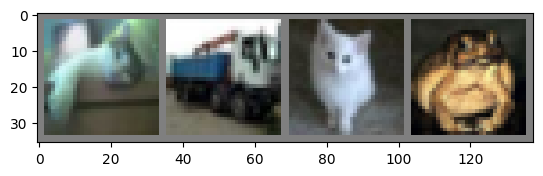

In [10]:
dataiter = iter(trainloader)
imgs, labels = next(dataiter)
imshow(torchvision.utils.make_grid(imgs))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [11]:
# 定义神经网络
import torch.nn as nn
import torch.nn.functional as F

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [13]:
net = Net()

In [14]:
# 定义损失函数和优化器
import torch.optim as optim

In [15]:
criterion = nn.CrossEntropyLoss() # 使用交叉熵作为损失函数

In [16]:
# 使用带动量的随机梯度下降做优化器
optimizer = optim.SGD(params=net.parameters(), lr=0.001, momentum=0.9) 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cup')

In [17]:
# 训练网络
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()  # 梯度置零
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # 打印训练状态
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d %5d] loss: %.3f' % (epoch+1, i+1, running_loss/2000))
            running_loss = 0.0
print('-------------FINISHED TRAINING---------------')

[1  2000] loss: 2.146
[1  4000] loss: 1.778
[1  6000] loss: 1.636
[1  8000] loss: 1.570
[1 10000] loss: 1.503
[1 12000] loss: 1.453
[2  2000] loss: 1.379
[2  4000] loss: 1.346
[2  6000] loss: 1.331
[2  8000] loss: 1.307
[2 10000] loss: 1.278
[2 12000] loss: 1.272
-------------FINISHED TRAINING---------------


GroundTruth:   cat  ship  ship plane


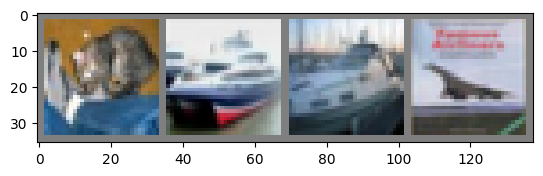

In [18]:
dataiter = iter(testlodaer)
imgs, labels = next(dataiter)
imshow(torchvision.utils.make_grid(imgs))
print('GroundTruth:', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [19]:
outputs = net(imgs)

In [20]:
'''
values=tensor([2.7955, 7.1851, 3.4679, 5.1072], grad_fn=<MaxBackward0>),
indices=tensor([3, 1, 1, 0]))
max返回两个值， 第一个为每一行的最大值， 第二个为索引
'''
_, predicted = torch.max(outputs, dim=1)
print('Predicted:', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Predicted:   cat  ship  ship plane


In [21]:
# 查看在测试集上的预测结果
correct = 0
total = 0
with torch.no_grad():
    for data in testlodaer:
        imgs, labels = data
        outputs = net(imgs)
        _, predicted = torch.max(outputs, dim=1)
        total += labels.size(dim=0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on the testset: %d %%' % (100 * correct / total))

Accuracy of the network on the testset: 55 %


In [22]:
# 查看在每个类上的预测效果
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testlodaer:
        imgs, labels = data
        outputs = net(imgs)
        _, predicted = torch.max(outputs, dim=1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' %(classes[i], class_correct[i] / class_total[i] * 100))

Accuracy of plane : 53 %
Accuracy of   car : 73 %
Accuracy of  bird : 42 %
Accuracy of   cat : 25 %
Accuracy of  deer : 47 %
Accuracy of   dog : 47 %
Accuracy of  frog : 83 %
Accuracy of horse : 55 %
Accuracy of  ship : 78 %
Accuracy of truck : 46 %


In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cup')
print(device)

cuda
